# TensorFlow Datasets

TensorFlow Datasets provides a collection of datasets ready to use with TensorFlow. It handles downloading and preparing the data and constructing a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [0]:
#@title Copyright 2018 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0 (show header)
# Copyright 2018 The TensorFlow Datasets Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Installation

`pip install tensorflow-datasets`

Note that `tensorflow-datasets` expects you to have TensorFlow already installed, and currently depends on `tf-nightly` (or `tf-nightly-gpu`).

In [0]:
!pip install -q tf-nightly tensorflow-datasets matplotlib

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

DATA_DIR="~/tensorflow_datasets/data"

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


## Eager execution

TensorFlow Datasets is compatible with both TensorFlow [Eager mode](https://www.tensorflow.org/guide/eager) and Graph mode. For this colab, we'll run in Eager mode.

In [0]:
tf.enable_eager_execution()

## List the available datasets

Each dataset is implemented as a [`tfds.DatasetBuilder`](https://www.tensorflow.org/datasets/api_docs/python/tfds/DatasetBuilder) and you can list all available builders with `tfds.list_builders()`.

In [6]:
tfds.list_builders()

['cifar10', 'cifar100', 'fashion_mnist', 'mnist']

## `tfds.load`: A dataset in one line

[`tfds.load`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) is a convenience method that's the simplest way to build and load and `tf.data.Dataset`.

Below, we load the MNIST training data. Setting `download=True` will download and prepare the data. Note that it's safe to call `load` multiple times with `download=True` as long as the builder `name` and `data_dir` remain the same. The prepared data will be reused.

In [7]:
mnist_train = tfds.load(name="mnist",
                        split=tfds.Split.TRAIN,
                        data_dir=DATA_DIR,
                        download=True)
assert isinstance(mnist_train, tf.data.Dataset)
mnist_train

INFO:tensorflow:Skipping download_and_prepare for splits [<Split.TRAIN: 'train'>] as all files exist.
INFO:tensorflow:Skipping download_and_prepare for splits [<Split.TEST: 'test'>] as all files exist.


<MapDataset shapes: {input: (28, 28, 1), target: ()}, types: {input: tf.uint8, target: tf.int64}>

## Feature dictionaries

All `tfds` datasets contain feature dictionaries mapping feature names to Tensor values. A typical dataset, like MNIST, will have 2 keys: `"input"` and `"target"`. Below we inspect a single record.

Label: 8


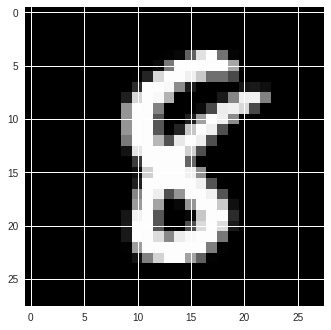

In [8]:
mnist_example, = mnist_train.take(1)
image, label = mnist_example["input"], mnist_example["target"]

plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap('gray'))
print("Label: %d" % label.numpy())

## `DatasetBuilder`

`tfds.load` is really a thin conveninence wrapper around `DatasetBuilder`. We can accomplish the same as above directly with the MNIST `DatasetBuilder`.

In [9]:
mnist_builder = tfds.builder("mnist", data_dir=DATA_DIR)
mnist_builder.download_and_prepare()
mnist_train = mnist_builder.as_dataset(split=tfds.Split.TRAIN)
mnist_train

INFO:tensorflow:Skipping download_and_prepare for splits [<Split.TRAIN: 'train'>] as all files exist.
INFO:tensorflow:Skipping download_and_prepare for splits [<Split.TEST: 'test'>] as all files exist.


<MapDataset shapes: {input: (28, 28, 1), target: ()}, types: {input: tf.uint8, target: tf.int64}>

## Input pipelines

Once you have a `tf.data.Dataset` object, it's simple to define the rest of an input pipeline suitable for model training by using the [`tf.data` API](https://www.tensorflow.org/guide/datasets).

Here we'll repeat the dataset so that we have an infinite stream of examples, shuffle, and create batches of 32.

In [10]:
mnist_train = mnist_train.repeat().shuffle(1024).batch(32)

# prefetch will enable the input pipeline to asynchronously fetch batches while
# your model is training.
mnist_train = mnist_train.prefetch(100)

# Now you could loop over batches of the dataset and train
# for batch in mnist_train:
#   ...

<PrefetchDataset shapes: {input: (?, 28, 28, 1), target: (?,)}, types: {input: tf.uint8, target: tf.int64}>